# Vanguard Portfolio Optimizer (using vanguard historical data)

## Initialization

In [1]:
%matplotlib inline

In [2]:
import requests
import re
import json
import typing

import pandas as pd
import numpy as np
import requests_cache
import cvxpy as cp
import matplotlib.pyplot as plt
import seaborn as sns

from statsmodels.stats.outliers_influence import variance_inflation_factor

In [3]:
requests_cache.install_cache('vanguard', backend='sqlite')

In [4]:
PRODUCT_URL = "https://api.vanguard.com/rs/gre/gra/1.7.0/datasets/urd-product-list.json"
REQUEST_URL = "https://api.vanguard.com/rs/gre/gra/1.7.0/datasets/urd-product-port-specific-price-history.json?vars=portId:{port_id},issueType:S,startDate:{start_date:%Y-%m-%d},endDate:{end_date:%Y-%m-%d}"
ASSET_COLOURS = {
    "BOND": "red",
    "EQUITY": "green"
}
CUTOFF_YEAR = 2015

END_DATE = pd.to_datetime("2021-01-01")

## Get products descriptions

In [6]:
def get_products() -> pd.DataFrame:
    request = requests.get(PRODUCT_URL)
    assert request.status_code == 200
    return json.loads(request.text)

def len_or(value, none_value=1) -> int:
    return none_value if value is None else len(value)


def products_json_to_df(products_json) -> pd.DataFrame:
    return (
        pd.DataFrame(products_json.values())
        .assign(
            fees=lambda x: x['OCF'].str.slice(0,-1).astype(float) / 100,
            assets= lambda x: x['assetAllocations'].apply(len_or),
            inceptionDate=lambda x: pd.to_datetime(x['inceptionDate'])
        )
        [
            lambda x: 
            (x['distributionStrategyType'] == 'ACCM')
            & x['assetCode'].isin(["BOND", "EQUITY"])
            & (x['managementType'] == 'INDEX')
            & ~x['name'].str.startswith('ESG ')
            & ~x['name'].str.startswith('SRI ')
            & (x['inceptionDate'].dt.year <= CUTOFF_YEAR)
        ]
        .reset_index(drop=True)
    )
    

products_df = products_json_to_df(get_products())

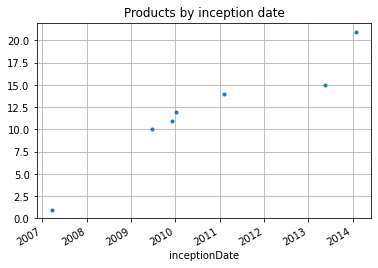

In [7]:
ax = products_df.groupby('inceptionDate').size().sort_index().cumsum().plot(grid=True, style='.')
ax.set_title('Products by inception date');

## Get products historical prices

In [8]:
histories = {}

for _, product in products_df.iterrows():
    port_id = product['portId']
    url = REQUEST_URL.format(
        port_id=port_id,
        start_date=product['inceptionDate'],
        end_date=END_DATE
    )
    request = requests.get(url)
    assert request.status_code == 200
    
    histories[port_id] = json.loads(request.text)



In [9]:
sedols = products_df.set_index('portId')['sedol'].to_dict()
dfs = []
for port_id, history in histories.items():
    df = (
        pd.DataFrame(history)
        .assign(
            date=lambda x: pd.to_datetime(x['date'], utc=True).dt.tz_localize(None).dt.normalize()
        )
        .drop(columns=['mmNavPrice'])
        .rename(columns={'navPrice': 'price'})
        .sort_values('date', ignore_index=True)
        .assign(
            sedol=sedols[port_id],
            day_return=lambda x: (x['price'] - x['price'].shift()) /  x['price'].shift(),
        )
    )
    dfs.append(df)
historical_df = pd.concat(dfs, ignore_index=True)    

## Explore products stats

In [10]:
stats = (
    historical_df.groupby('sedol')['day_return']
    .describe()[['count', 'mean', 'std']]
    .add_prefix('return_')
    .assign(
        yearly_return_mean=lambda x: (1+x['return_mean'])**252 -1,
        yearly_return_std=lambda x: x['return_std']*np.sqrt(252),
    )
)

In [11]:
products_stats_df = products_df.join(stats, on='sedol')

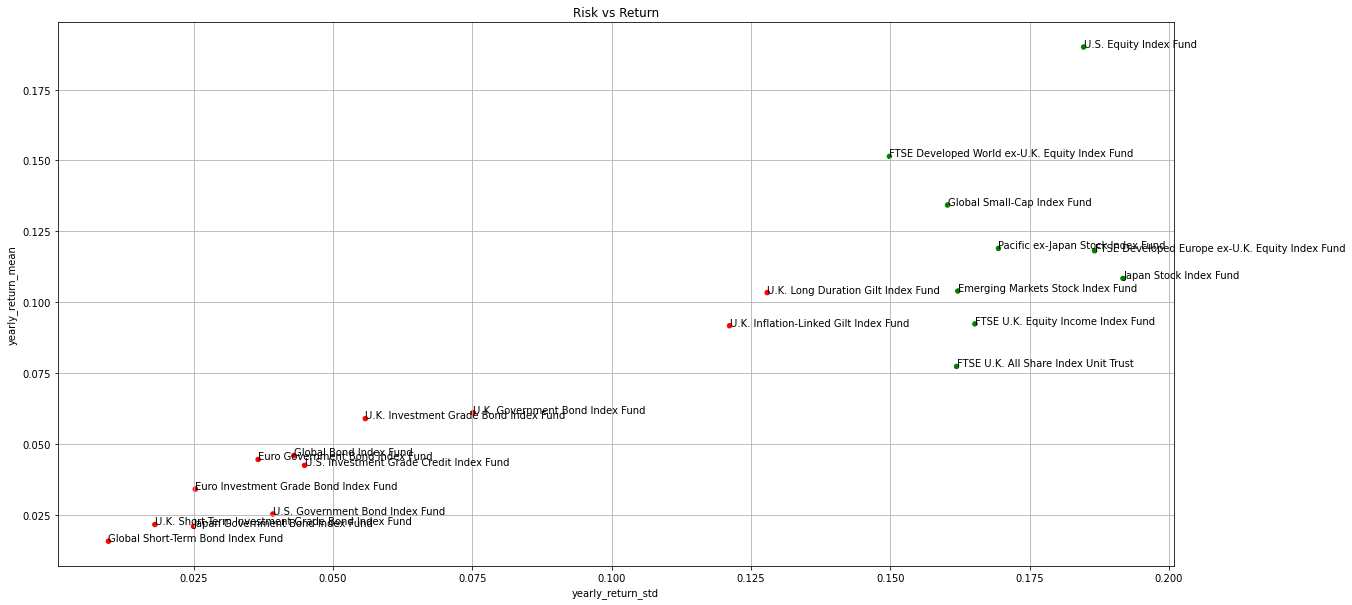

In [12]:
ax = (
    products_stats_df
    #.set_index('year_std')
    .plot.scatter(
        x='yearly_return_std',
        y='yearly_return_mean',
        grid=True,
        figsize=(20, 10),
        c=products_stats_df['assetCode'].map(ASSET_COLOURS)
    )
)

def label_point(x, y, val, ax):
    a = pd.concat({'x': x, 'y': y, 'val': val}, axis=1)
    for i, point in a.iterrows():
        ax.text(point['x'], point['y'], str(point['val']))

label_point(
    products_stats_df['yearly_return_std'], 
    products_stats_df['yearly_return_mean'], 
    products_stats_df['name'], 
    ax
)
_ = ax.set_title("Risk vs Return")

In [13]:
pivoted_prices = (
    historical_df
    .pivot(index='date', values='price', columns='sedol')
    .dropna(how='any')
)

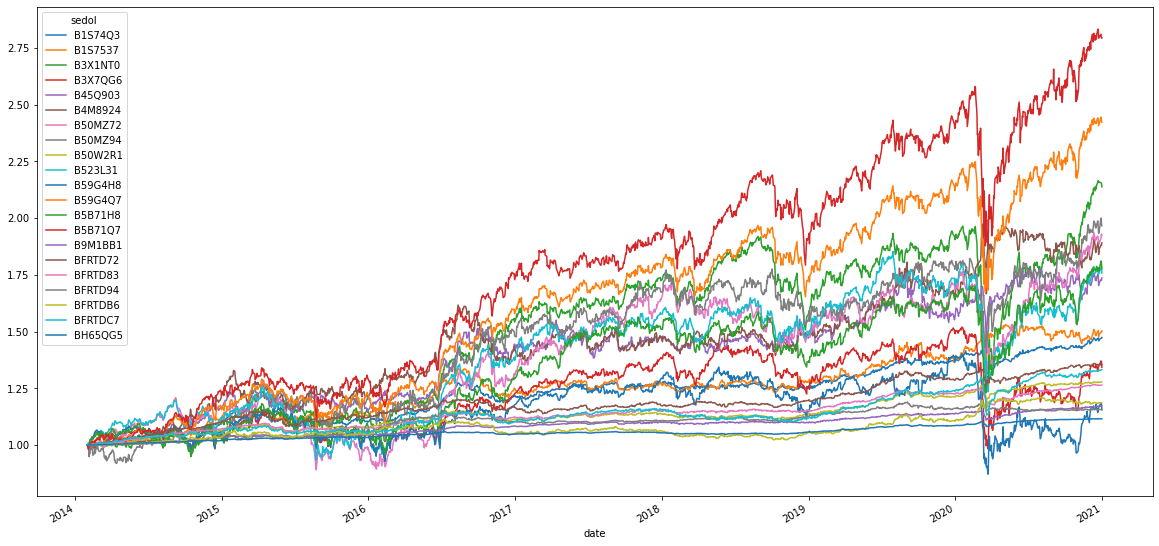

In [14]:
_ = (
    pivoted_prices
    .div(pivoted_prices.iloc[0], axis=1)
    .plot(figsize=(20,10))
)

## Prepare optimization inputs

In [15]:
pivoted_returns = (
    historical_df
        .pivot(index=['date'], columns=['sedol'], values=['day_return'])
        .droplevel(0, axis=1)
        .dropna(how='any')
        [lambda x: sorted(x.columns)]
)

In [16]:
covariance = (
        pivoted_returns.cov().sort_index()[lambda x: sorted(x.columns)]
)
expected_returns = pivoted_returns.mean()

In [17]:
class ProblemVariables:
    
    def __init__(self, expected_returns, covariance):
        
        assert (expected_returns.index == covariance.index).all()
        self.index = expected_returns.index
        er = expected_returns.to_numpy()
        cov = np.asmatrix(covariance.to_numpy())
        self.x = cp.Variable(len(expected_returns))
        self.vol = cp.quad_form(self.x, np.asmatrix(cov))
        self.ret = er.T @ self.x
        
    def results(self):
        return self.ret.value, self.std()
    
    def std(self):
        return np.sqrt(self.vol.value)
        
    
    def year_std(self):
        return self.std() * np.sqrt(253)
    
    def year_return(self):
        return (1 + self.ret.value)**253 - 1
    
    def full_results(self):
        results = dict(zip(self.index, self.x.value))
        results['return'] = self.year_return()
        results['std'] = self.year_std()
        return pd.Series(results)
    
    def maximize_returns(self):
        cp.Problem(cp.Maximize(self.ret), [sum(self.x) == 1, self.x >= 0]).solve(solver='CVXOPT')
        return self
        
    def minimize_std(self):
        cp.Problem(cp.Minimize(self.vol), [sum(self.x) == 1, self.x >= 0]).solve(solver='CVXOPT')
        return self

    def solve_for_std(self, std_limit):
        cp.Problem(
            cp.Maximize(self.ret),
              [
                  self.vol <= std_limit**2,
                  cp.sum(self.x) == 1, 
                  self.x >= 0,
              ]
         ).solve(solver='CVXOPT')
        return self
        
    def iterate_stds(self, points):
        min_std = self.minimize_std().std()
        max_std = self.maximize_returns().std()
        
        std_values = np.linspace(min_std, max_std, points)
        results = []
        for std_limit in std_values:
            results.append(self.solve_for_std(std_limit).full_results())
        return pd.DataFrame(results)

    def solve_for_return(self, return_limit):
        prob = cp.Problem(
            cp.Minimize(self.vol),
              [
                  self.ret >= return_limit,
                  cp.sum(self.x) == 1, 
                  self.x >= 0,
              ]
         ).solve(solver='CVXOPT')
        return self
    
    def iterate_returns(self, points):
        min_return = self.minimize_std().ret.value
        max_return = self.maximize_returns().ret.value
        
        return_values = np.linspace(min_return, max_return, points)
        
        results = []
        for return_value in return_values:
            results.append(self.solve_for_return(return_value).full_results())
        return pd.DataFrame(results)

std_ptfs = ProblemVariables(expected_returns, covariance).minimize_std().iterate_stds(200)

In [18]:
def renormalize(df):
    row_sum = df.sum(axis=1)
    return df.div(row_sum, axis=0)


def plot_ptfs(ptfs, products_df, key='std'):
    assert key in ('std', 'return')
    mapping = products_df.set_index('sedol')['name'].to_dict()

    return (
        ptfs
        .drop(columns=['return' if key == 'std' else 'std'])
        .set_index('std' if key == 'std' else 'return')
        .mask(lambda x: x < 0.01)
        .fillna(0)
        .loc[:, lambda x:(x != 0).any(axis=0)]
        .pipe(renormalize)
        .rename(columns=mapping)
        .plot
        .area(figsize=[20,10], grid=True, legend='reverse')
    )

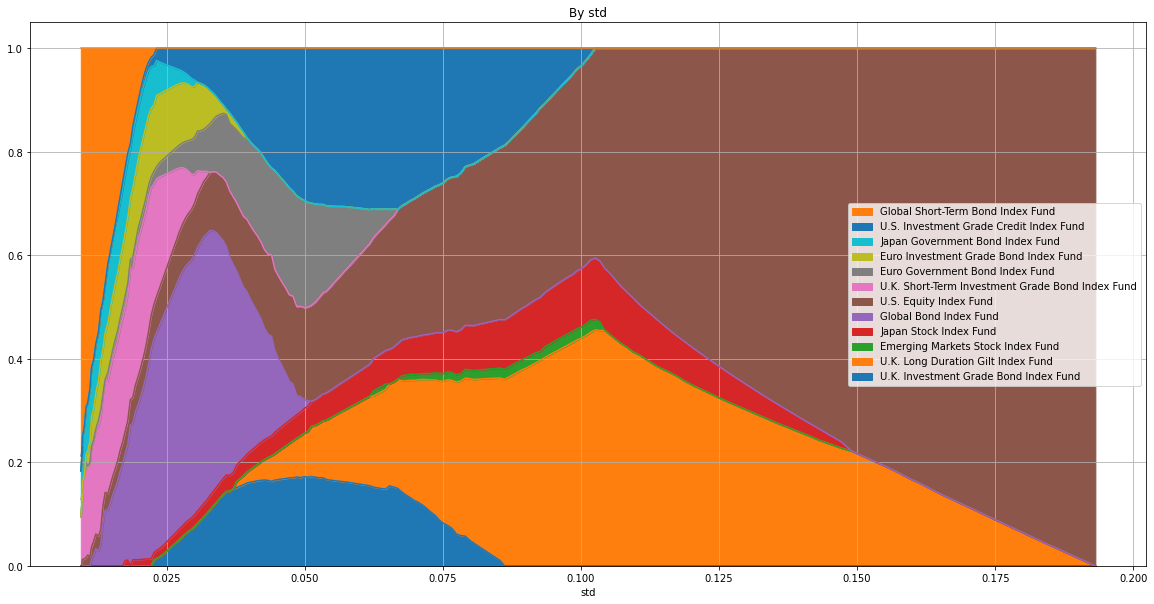

In [19]:
_ = plot_ptfs(returns_ptfs, products_df, key='std').set_title("By std")